In [34]:
#this code with reload any imports if you're updating them actively
%reload_ext autoreload
%autoreload 2
import pygem_eb.input as eb_prms
#import scipy.obinimize as obin
import numpy as np
import xarray as xr
import pandas as pd
import os
#import suncalc as solar
import yaml
#PyGEM
import pygem.pygem_input as pygem_prms
import pygem.oggm_compat as oggm
import pygem.pygem_modelsetup as modelsetup
import class_climate

1 bins at elevations: [1546] [m]


In [2]:
import os 
os.getcwd()

'/home/claire/research/PyGEM-EB'

In [1]:
import sys, os, yaml
sys.path.append('/home/claire/research/PyGEM-EB/biosnicar-py/src/')
import biosnicar as snicar
fp = '/home/claire/research/PyGEM-EB/biosnicar-py/src/biosnicar/inputs.yaml'
output_dict = dict()
run = 0


** Validating model configuration **
snow algae OK
illumination OK
ice OK
glacier algae OK

Running biosnicar with the adding-doubling solver



In [30]:
with open(fp) as f:
    list_doc = yaml.safe_load(f)
n_layers = 3
# Update changing layer variables
BC = [3e-6,2e-7,3e-6]
dust = [3e-3,2e-3,3e-3]
rho = [800,300,150]
grainsize = [60,800,1200]

list_doc['IMPURITIES']['BC']['CONC'] = BC
list_doc['IMPURITIES']['DUST1']['CONC'] = [d*0.1 for d in dust]
list_doc['IMPURITIES']['DUST2']['CONC'] = [d*0.2 for d in dust]
list_doc['IMPURITIES']['DUST3']['CONC'] = [d*0.4 for d in dust]
list_doc['IMPURITIES']['DUST4']['CONC'] = [d*0.2 for d in dust]
list_doc['IMPURITIES']['DUST5']['CONC'] = [d*0.1 for d in dust]
list_doc['ICE']['DZ'] = [1,0.05,0.01]
list_doc['ICE']['RHO'] = rho
list_doc['ICE']['RDS'] = grainsize

# Following variables are set to constants, but need to have right number of layers
ice_variables = ['LAYER_TYPE','SHP','HEX_SIDE','HEX_LENGTH','SHP_FCTR','WATER','AR','CDOM']
for var in ice_variables:
    list_doc['ICE'][var] = [list_doc['ICE'][var][0]] * n_layers

# Save SNICAR input file
with open(fp, 'w') as f:
    yaml.dump(list_doc,f)

albedo = snicar.main.get_albedo('adding-doubling',plot=False,validate=False)
print(albedo)

output_dict[run] = {'BC':BC,'dust':dust,'grainsize':grainsize,
                    'rho':rho,'albedo':albedo}

run += 1


Running biosnicar with the adding-doubling solver

0.8393356593539523


In [32]:
for i in range(len(output_dict)):
    print('BC:',sum(output_dict[i]['BC']),'grain size:',output_dict[i]['grainsize'],'albedo:',output_dict[i]['albedo'])

BC: 1.5e-06 grain size: [1500, 200, 200] albedo: 0.6735420373725209
BC: 1.5e-06 grain size: [1500, 200, 60] albedo: 0.6735493699844556
BC: 1.5e-06 grain size: [1500, 200, 800] albedo: 0.6735396328535006
BC: 5.5e-06 grain size: [1500, 200, 800] albedo: 0.6735396259817485
BC: 4.2000000000000004e-06 grain size: [1500, 200, 800] albedo: 0.6735397836604292
BC: 4.2000000000000004e-06 grain size: [1500, 800, 1200] albedo: 0.6735072105733765
BC: 4.2000000000000004e-06 grain size: [60, 800, 1200] albedo: 0.8393356593539523


In [2]:
# ===== GLACIER AND TIME PERIOD SETUP =====
glacier_table = modelsetup.selectglaciersrgitable(eb_prms.glac_no,
                rgi_regionsO1=eb_prms.rgi_regionsO1, rgi_regionsO2=eb_prms.rgi_regionsO2,
                rgi_glac_number=eb_prms.rgi_glac_number, include_landterm=eb_prms.include_landterm,
                include_laketerm=eb_prms.include_laketerm, include_tidewater=eb_prms.include_tidewater)
dates_table = pd.DataFrame({'date' : pd.date_range(eb_prms.startdate,eb_prms.enddate,freq='h')})
# Extract attributes for dates_table
dates_table['year'] = dates_table['date'].dt.year
dates_table['month'] = dates_table['date'].dt.month
dates_table['day'] = dates_table['date'].dt.day
dates_table['hour'] = dates_table['date'].dt.hour
dates_table['daysinmonth'] = dates_table['date'].dt.daysinmonth
dates_table['timestep'] = np.arange(len(dates_table['date']))
# Set date as index
dates_table.set_index('timestep', inplace=True)

# Remove leap year days if user selected this with option_leapyear
if eb_prms.option_leapyear == 0:
    # First, change 'daysinmonth' number
    mask1 = dates_table['daysinmonth'] == 29
    dates_table.loc[mask1,'daysinmonth'] = 28
    # Next, remove the 29th days from the dates
    mask2 = ((dates_table['month'] == 2) & (dates_table['day'] == 29))
    dates_table.drop(dates_table[mask2].index, inplace=True)
    dates_table['timestep'] = np.arange(len(dates_table['date']))
    dates_table.set_index('timestep', inplace=True)

# Add column for water year
# Water year for northern hemisphere using USGS definition (October 1 - September 30th),
# e.g., water year for 2000 is from October 1, 1999 - September 30, 2000
dates_table['wateryear'] = dates_table['year']
for step in range(dates_table.shape[0]):
    if dates_table.loc[step,'month'] >= 10:
        dates_table.loc[step,'wateryear'] = dates_table.loc[step,'year'] + 1

1 glaciers in region 1 are included in this model run: ['00570']
This study is focusing on 1 glaciers in region [1]


In [3]:
#%% MODEL PROPERTIES
density_ice = 900           # Density of ice [kg m-3] (or Gt / 1000 km3)
density_water = 1000        # Density of water [kg m-3]
area_ocean = 362.5 * 1e12   # Area of ocean [m2] (Cogley, 2012 from Marzeion et al. 2020)
k_ice = 2.33                # Thermal conductivity of ice [J s-1 K-1 m-1] recall (W = J s-1)
k_air = 0.023               # Thermal conductivity of air [J s-1 K-1 m-1] (Mellor, 1997)
k_air = 0.001               # Thermal conductivity of air [J s-1 K-1 m-1]
ch_ice = 1890000            # Volumetric heat capacity of ice [J K-1 m-3] (density=900, heat_capacity=2100 J K-1 kg-1)
ch_air = 1297               # Volumetric Heat capacity of air [J K-1 m-3] (density=1.29, heat_capacity=1005 J K-1 kg-1)
Lh_rf = 333550              # Latent heat of fusion [J kg-1]
tolerance = 1e-12           # Model tolerance (used to remove low values caused by rounding errors)
gravity = 9.81              # Gravity [m s-2]
pressure_std = 101325       # Standard pressure [Pa]
temp_std = 288.15           # Standard temperature [K]
R_gas = 8.3144598           # Universal gas constant [J mol-1 K-1]
molarmass_air = 0.0289644   # Molar mass of Earth's air [kg mol-1]


# MORE FACTORS THAT MIGHT BE NECESSARY
kp = 1                              # precipitation factor [-] (referred to as k_p in Radic etal 2013; c_prec in HH2015)
tbias = 5                           # temperature bias [deg C]
ddfsnow = 0.0041                    # degree-day factor of snow [m w.e. d-1 degC-1]
ddfsnow_iceratio = 0.7              # Ratio degree-day factor snow snow to ice
ddfice = ddfsnow / ddfsnow_iceratio # degree-day factor of ice [m w.e. d-1 degC-1]
precgrad = 0.0001                   # precipitation gradient on glacier [m-1]
lapserate = -0.0065                 # temperature lapse rate for both gcm to glacier and on glacier between elevation bins [K m-1]
tsnow_threshold = 1                 # temperature threshold for snow [deg C] (HH2015 used 1.5 degC +/- 1 degC)
calving_k = 0.7                     # frontal ablation rate [yr-1]

# MORE THAT I ADDED JUST FOR THE ENERGY BALANCE
Cp_water = 4184                     # Isobaric heat capacity of water [J kg-1 K-1]
Cp_air = 1005                       # Isobaric heat capacity of air [J kg-1 K-1]
Cp_ice = 2050                       # Isobaric heat capacity of ice [J kg-1 K-1]
Lv_evap = 2.514e6                   # latent heat of evaporation [J kg-1]
Lv_sub = 2.849e6                    # latent heat of sublimation [J kg-1]
k_vK = 0.4                          # von Karman's constant
density_std = 1.225                 # air density at sea level [kg m^-3]

In [4]:
# ===== LOAD CLIMATE DATA =====
gcm = class_climate.GCM(name='ERA5-hourly')
gcm_prec, gcm_hours = gcm.importGCMvarnearestneighbor_xarray(gcm.prec_fn, gcm.prec_vn, glacier_table,dates_table)
gcm_temp, gcm_hours = gcm.importGCMvarnearestneighbor_xarray(gcm.temp_fn, gcm.temp_vn, glacier_table,dates_table)
gcm_dtemp, gcm_hours = gcm.importGCMvarnearestneighbor_xarray(gcm.dtemp_fn, gcm.dtemp_vn, glacier_table,dates_table)
gcm_sp, gcm_hours = gcm.importGCMvarnearestneighbor_xarray(gcm.press_fn, gcm.press_vn, glacier_table,dates_table)
gcm_tcc, gcm_hours = gcm.importGCMvarnearestneighbor_xarray(gcm.tcc_fn, gcm.tcc_vn, glacier_table,dates_table)
gcm_surfrad, gcm_hours = gcm.importGCMvarnearestneighbor_xarray(gcm.surfrad_fn, gcm.surfrad_vn, glacier_table,dates_table) 
gcm_uwind, gcm_hours = gcm.importGCMvarnearestneighbor_xarray(gcm.uwind_fn, gcm.uwind_vn, glacier_table,dates_table)                                                      
gcm_vwind, gcm_hours = gcm.importGCMvarnearestneighbor_xarray(gcm.vwind_fn, gcm.vwind_vn, glacier_table,dates_table)

gcm_elev = gcm.importGCMfxnearestneighbor_xarray(gcm.elev_fn, gcm.elev_vn, glacier_table)

!! Not checking units for any EB variables
!! Not checking units for any EB variables
!! Not checking units for any EB variables
!! Not checking units for any EB variables
!! Not checking units for any EB variables
!! Not checking units for any EB variables


In [5]:
# READ GULKANA ELEVATION DATA FROM RGI 6.0
gulkana = '01.00570'
glac_no = [gulkana]

# ----- RGI DATA -----
# Filepath for RGI files
main_directory = os.getcwd()
elev_points = glacier_table[['Zmin','Zmed','Zmax']]

In [6]:
# READ GULKANA ELEVATIONS FROM OGGM GDIRS
#this step is specific to the EB for three points on Gulkana
#to generalize, need a variable geometry containing zwh for the points for the EB
glac_no = pygem_prms.glac_no
gdir = oggm.single_flowline_glacier_directory(glac_no[0], logging_level='CRITICAL')
fls = oggm.get_glacier_zwh(gdir)
#filter out zero bins to get only initial glacier volume
fls = fls.iloc[np.nonzero(fls['h'].to_numpy())]
z_stats = np.array([np.min(fls['z']),np.median(fls['z']),np.max(fls['z'])])

#setup three points at minimum, median and maximum elevation band from OGGM
median_index = np.where(fls['z']==z_stats[1])[0][0]
w_stats = np.array([fls['w'][len(fls)-1],fls['w'][median_index],fls['w'][0]])
h_stats = np.array([fls['h'][len(fls)-1],fls['h'][median_index],fls['h'][0]])
geo_index = ['Bottom','Middle','Top']
geometry = pd.DataFrame({'z':z_stats,'w':w_stats,'h':h_stats},index=geo_index)
n_points = len(geo_index)


In [7]:
# ===== SET UP CLIMATE DATASETS =====
#create dataset to store variables that need to be downscaled by elevation
#if we want to be able to run multiple glaciers at once, this will need to be updated to add 'glacier' as a coordinate
bin_idx = [0,1,2]
bin_name = ['Bottom','Middle','Top']
climateds = xr.Dataset(data_vars = dict(
    bin_elev = (['bin'],z_stats,{'units':'m'}),
    bin_idx = (['bin'],bin_idx),
    surfrad = (['time'],gcm_surfrad[0],{'units':'J m-2'}),
    tcc = (['time'],gcm_tcc[0],{'units':'0-1'}),
    uwind = (['time'],gcm_uwind[0],{'units':'m s-1'}),
    vwind = (['time'],gcm_vwind[0],{'units':'m s-1'})),
    coords=dict(
        bin=(['bin'],bin_name),
        time=(['time'],gcm_hours)
        ))

#initialize variables to be adjusted
temp_adj = np.zeros((n_points,len(gcm_hours)))
prec_adj = np.zeros((n_points,len(gcm_hours)))
sp_adj = np.zeros((n_points,len(gcm_hours)))
rh_adj = np.zeros((n_points,len(gcm_hours)))
density_adj = np.zeros((n_points,len(gcm_hours)))
dtemp_adj = np.zeros((n_points,len(gcm_hours)))

# define function to calculate vapor pressure (needed for RH)
e_func = lambda T_C: 610.94*np.exp(17.625*T_C/(T_C+243.04))  #vapor pressure in Pa, T in Celsius

#loop through each elevation bin and adjust climate variables by lapse rate/barometric law
for idx,z in enumerate(climateds['bin_elev'].values):
    temp_adj[idx,:] = gcm_temp + eb_prms.lapserate*(z-gcm_elev)
    dtemp_adj[idx,:] = gcm_dtemp + eb_prms.lapserate_dew*(z-gcm_elev) - 273.15
    prec_adj[idx,:] = gcm_prec*eb_prms.kp*(1+eb_prms.precgrad*(z-gcm_elev))
    sp_adj[idx,:] = gcm_sp*np.power((gcm_temp + eb_prms.lapserate*(z-gcm_elev)+273.15)/(gcm_temp+273.15),
                           -eb_prms.gravity*eb_prms.molarmass_air/(eb_prms.R_gas*eb_prms.lapserate))
    rh_adj[idx,:] = e_func(dtemp_adj[idx,:]) / e_func(temp_adj[idx,:]) * 100
    density_adj[idx,:] = sp_adj[idx,:]/eb_prms.R_gas/(temp_adj[idx,:]+273.15)*eb_prms.molarmass_air

climateds = climateds.assign(bin_temp = (['bin','time'],temp_adj,{'units':'C'}))
climateds = climateds.assign(bin_dtemp = (['bin','time'],dtemp_adj,{'units':'C'}))
climateds = climateds.assign(bin_tp = (['bin','time'],prec_adj,{'units':'m'}))
climateds = climateds.assign(bin_sp = (['bin','time'],sp_adj,{'units':'Pa'}))
climateds = climateds.assign(bin_rh = (['bin','time'],rh_adj,{'units':'%'}))
climateds = climateds.assign(bin_density = (['bin','time'],density_adj,{'units':'kg m-3'}))
print('!! Using constant (not calibrated) kp and lapserate')


!! Using constant (not calibrated) kp and lapserate


In [8]:
print(rh_adj)
print(np.max(rh_adj))

[[ 64.52960834  65.30043435  64.60419667 ...  57.0955032   56.24159443
   56.06494608]
 [ 78.64772175  79.61099288  78.81284947 ...  69.04863189  67.99366131
   67.76523179]
 [108.30162373 109.68134546 108.69829105 ...  93.87797503  92.39460994
   92.05102949]]
144.95971236620596


In [8]:
xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_surfrad_hourly.nc')

<xarray.Dataset>
Dimensions:    (longitude: 1, latitude: 1, time: 368184)
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.34
  * time       (time) datetime64[ns] 1980-01-01 ... 2021-12-31T23:00:00
Data variables:
    ssrd       (time, latitude, longitude) float32 ...
Attributes:
    units:          J m**-2
    long_name:      Surface solar radiation downwards
    standard_name:  surface_downwelling_shortwave_flux_in_air

In [10]:
import matplotlib.pyplot as plt
%load_ext line_profiler
%reload_ext autoreload
%autoreload 2
import pygem_eb.energybalance as eb
import pygem_eb.layers as eb_layers
import pygem_eb.massbalance as mb



temp_prof = np.array([[0,-30],[1,-10],[5,-8],[10,0]])
density_prof = np.array([[0,100],[1,300],[5,350],[10,600]])
layer_depths = [[1,0,20],[4,.5,40],[5,2,40]]
bin = 0
massbal = mb.massBalance(bin)
time = climateds['time'].to_pandas()[0]
enbal = eb.energyBalance(climateds,time,bin,massbal.dt)
surftemp = np.arange(-50,10)
albedo = 0.85


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
6 layers initialized for bin 0


In [11]:
%lprun -f massbal.main massbal.main(climateds)

January 1980 for bin no 0
|    Qm: -0 W/m2              Melt: 0.00 m w.e.  |
| Air temp: -21.111 C       Accum: 0.02 m w.e.   |
-------------surface temp: -19.54 C-------------
             snow height: 0.60 m
|    8 layers total, only displaying top few     |
--------------------layer 0---------------------
     T = -22.6 C                 h = 0.048 m     
                 p = 104 kg/m3
Water Mass : 0.00 kg/m2   Dry Mass : 5.03 kg/m2
--------------------layer 1---------------------
     T = -18.5 C                 h = 0.033 m     
                 p = 106 kg/m3
Water Mass : 0.00 kg/m2   Dry Mass : 3.49 kg/m2
--------------------layer 2---------------------
     T = -18.9 C                 h = 0.114 m     
                 p = 115 kg/m3
Water Mass : 0.00 kg/m2   Dry Mass : 13.17 kg/m2
Unsuccessful minimization, Qm =  -10.403325592806288
February 1980 for bin no 0
|    Qm: -0 W/m2              Melt: 0.00 m w.e.  |
| Air temp: -9.395 C       Accum: 0.01 m w.e.   |
-------------surface te

Timer unit: 1e-09 s

Total time: 526.803 s
File: /home/claire/research/PyGEM/pygem_eb/massbalance.py
Function: main at line 52

Line #      Hits         Time  Per Hit   % Time  Line Contents
    52                                               def main(self,climateds):
    53                                                   """
    54                                                   Runs the time loop and mass balance scheme to solve layer temperature
    55                                                   and density profiles. 
    56                                           
    57                                                   Parameters
    58                                                   ----------
    59                                                   climateds : xr.Dataset
    60                                                       Climate dataset containing temperature, precipitation, pressure, air density, wind speed,
    61                                       

In [2]:
precip = climateds['bin_prec'].to_numpy()[:,0]
print(np.mean(precip),np.max(precip))

NameError: name 'climateds' is not defined

In [4]:
import pygem.pygem_input as pygem_prms
import pygem.pygem_modelsetup as modelsetup
%load_ext line_profiler
%reload_ext autoreload
%autoreload 2
# ===== LOAD GLACIERS =====
main_glac_rgi = modelsetup.selectglaciersrgitable(glac_no=pygem_prms.glac_no)

# ===== TIME PERIOD =====
dates_table = modelsetup.datesmodelrun(startyear=pygem_prms.gcm_startyear, endyear=pygem_prms.gcm_endyear, spinupyears=pygem_prms.gcm_spinupyears,option_wateryear=pygem_prms.gcm_wateryear)

1 glaciers in region 8 are included in this model run: ['00213']
This study is focusing on 1 glaciers in region [8]


In [5]:
%lprun -f modelsetup.datesmodelrun modelsetup.datesmodelrun(startyear=pygem_prms.gcm_startyear, endyear=pygem_prms.gcm_endyear, spinupyears=pygem_prms.gcm_spinupyears,option_wateryear=pygem_prms.gcm_wateryear)

Timer unit: 1e-09 s

Total time: 13.6388 s
File: /home/claire/research/PyGEM/pygem/pygem_modelsetup.py
Function: datesmodelrun at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def datesmodelrun(startyear=pygem_prms.ref_startyear, endyear=pygem_prms.ref_endyear, 
    14                                                             spinupyears=pygem_prms.ref_spinupyears, option_wateryear=pygem_prms.ref_wateryear):
    15                                               """
    16                                               Create table of year, month, day, water year, season and number of days in the month.
    17                                           
    18                                               Parameters
    19                                               ----------
    20                                               startyear : int
    21                                                   starting ye

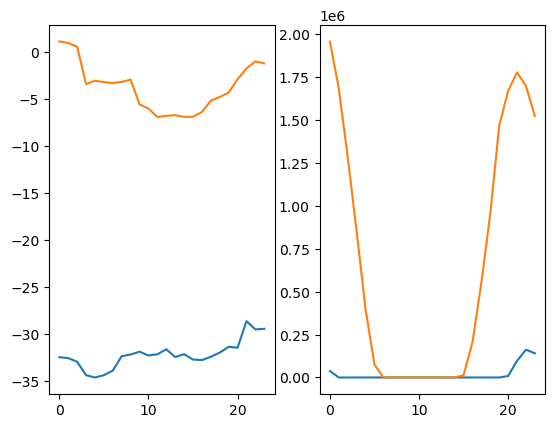

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
d = 100
fig,(ax1,ax2) = plt.subplots(1,2)
plotidx = np.arange(0,24)
T1 = climateds.isel({'time':plotidx})['bin_temp'][0]
SW1 = climateds.isel({'time':plotidx})['surfrad']
T2 = climateds.isel({'time':(plotidx+d*24)})['bin_temp'][0]
SW2 = climateds.isel({'time':(plotidx+d*24)})['surfrad']
time = pd.to_datetime(climateds.coords['time'].values[plotidx])
hours = [t.hour for t in time]
ax1.plot(hours,T1)
ax1.plot(hours,T2)
ax2.plot(hours,SW1)
ax2.plot(hours,SW2)
plt.show()

In [ ]:
import pygem_eb.energybalance as eb
import pygem_eb.layers as layers
import pygem_eb.input as eb_prms
temp_prof = pd.read_csv(eb_prms.initTemp_fp).to_numpy()[:,1:]
density_prof = pd.read_csv(eb_prms.initDensity_fp).to_numpy()[:,1:]
dt = eb_prms.dt
surftemp = 0
days_since_snowfall = 0
albedo = 0.85
layers = layers.Layers(temp_prof,density_prof,[10,2,18])

In [3]:
dayofyear = 0
ndays = 365
hoursperday = 1
fig,(ax1,ax2) = plt.subplots(2,1)
plotidx = np.arange(0,ndays*24,int(24/hoursperday))+24*dayofyear
time = pd.to_datetime(climateds.coords['time'].values[plotidx])
hours = [t.hour for t in time]
surftemp = 0

SWlist_in = []
SWlist_out = []
LWlist_in = []
LWlist_out = []
rainlist = []
senslist = []
latentlist = []
Qmlist = []
airtemplist = []
for t in time:
    enbal = eb.energyBalance(climateds,t,0,dt)
    SW,LW,rain,sens,latent = enbal.surfaceEB(surftemp,layers.depths,layers.types,days_since_snowfall,albedo,'list')
    SWlist_in.append(SW[0])
    LWlist_in.append(LW[0])
    SWlist_out.append(SW[1])
    LWlist_out.append(LW[1])
    rainlist.append(rain)
    senslist.append(sens)
    latentlist.append(latent)
    Qmlist.append(np.sum([SW[0],SW[1],LW[0],LW[1],rain,sens,latent]))
    airtemplist.append(enbal.tempC)

ax1.plot(time,airtemplist)
ax2.plot(time,Qmlist,'--',color='black',label='MELT E')
ax2.plot(time,senslist,label='sensible')
ax2.plot(time,latentlist,label='latent')
ax2.plot(time,rainlist,label='rain')
ax2.plot(time,SWlist_in,label='SW in')
ax2.plot(time,LWlist_in,label='LW_in')
ax2.plot(time,SWlist_out,label='SW out')
ax2.plot(time,LWlist_out,label='LW_out')
ax2.legend()
plt.gcf().autofmt_xdate()
plt.show()

NameError: name 'plt' is not defined

In [9]:
fp = eb_prms.output_filepath+'EB/'+str(eb_prms.model_run_date)[0:10].replace('-','_')+'.nc'
fp = '/home/claire/research/Output/EB/climateds.nc'
climateds.to_netcdf(fp,'w')

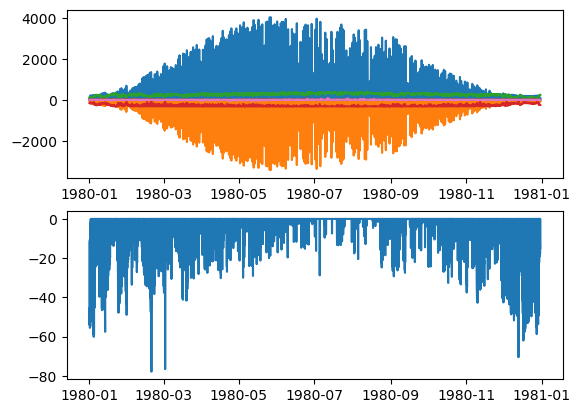

In [41]:
dayofyear = 0
ndays = 365
hoursperday = 1
fig,(ax1,ax2) = plt.subplots(2,1)
plotidx = np.arange(0,ndays*24,int(24/hoursperday))+24*dayofyear
ds = xr.open_dataset('/home/claire/research/Output/EB/run_2023_06_05_00.nc')
ax1.plot(ds.coords['time'],ds['SWin'],label='SWin')
ax1.plot(ds.coords['time'],ds['SWout'],label='SWout')
ax1.plot(ds.coords['time'],ds['LWin'],label='LWin')
ax1.plot(ds.coords['time'],ds['LWout'],label='LWout')
ax1.plot(ds.coords['time'],ds['rain'],label='rain')
ax1.plot(ds.coords['time'],ds['sensible'],label='sensible')
ax1.plot(ds.coords['time'],ds['latent'],label='latent')
ax2.plot(ds.coords['time'],ds['surftemp'],label='surftemp')

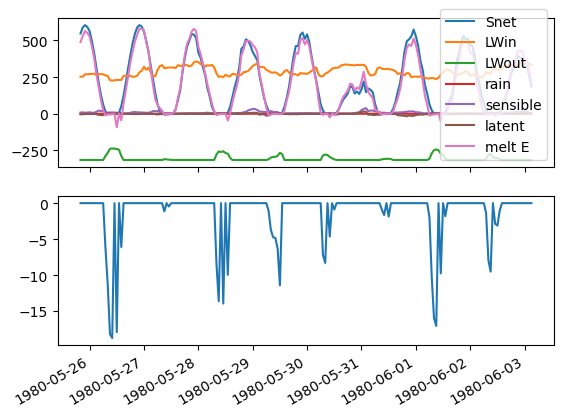

In [55]:
ds = xr.open_dataset('/home/claire/research/Output/EB/run_2023_06_05_00.nc')
fig,(ax1,ax2) = plt.subplots(2,1)
start = 3500
end = start + 200
time = ds.coords['time'][start:end]
# ax1.plot(time,ds['SWin'][start:end],label='SWin')
# ax1.plot(time,ds['SWout'][start:end],label='SWout')
ax1.plot(time,ds['SWout'][start:end]+ds['SWin'][start:end],label='Snet')
ax1.plot(time,ds['LWin'][start:end],label='LWin')
ax1.plot(time,ds['LWout'][start:end],label='LWout')
ax1.plot(time,ds['rain'][start:end],label='rain')
ax1.plot(time,ds['sensible'][start:end],label='sensible')
ax1.plot(time,ds['latent'][start:end],label='latent')
ax1.plot(time,ds['meltenergy'][start:end],label='melt E')
ax2.plot(time,ds['surftemp'][start:end],label='surftemp')
plt.gcf().autofmt_xdate()
ax1.legend()
plt.show()

In [14]:
a = np.array([1,2,3,4])
b = np.array([1,0,0,0])
a = np.array([[a[i],b[i]] for i in range(len(a))])
print(a)

[[1 1]
 [2 0]
 [3 0]
 [4 0]]


In [27]:
gdir = oggm.single_flowline_glacier_directory(eb_prms.glac_no[0], logging_level='CRITICAL')
fls = oggm.get_glacier_zwh(gdir)
fls = fls.iloc[np.nonzero(fls['h'].to_numpy())] #filter out zero bins to get only initial glacier volume
med_idx = np.where(fls['z'].to_numpy()==np.median(fls['z'].to_numpy()))[0]
bin_indices = np.linspace(len(fls.index)-1,0,eb_prms.n_bins,dtype=int)
bin_elev = fls.iloc[bin_indices]['z'].to_numpy()

density_prof = np.array([[0,100],[1,390],[2.5,485],[3.5,600]])
temp_prof = np.array([-10,-5,0,0]) # corresponding to density depth points
elev = fls['z'].to_numpy()
minmedmax_elev = np.array([elev[-1],elev[med_idx][0],elev[0]]) # min,median,max elevation in [m]
ice_depths = fls.iloc[[0,med_idx,len(fls.index)-1]]['h'].to_numpy()
firn_depths = np.array([0,0,2.5])
snow_depths = np.array([0,0,2])

densityds = xr.Dataset(data_vars = dict(
    snow_depth = (['bin_elev'],snow_depths),
    firn_depth = (['bin_elev'],firn_depths),
    ice_depth = (['bin_elev'],ice_depths),
    snow_density = (['layer_depth'],density_prof[:,1]),
    snow_temp = (['layer_depth'],temp_prof)),
    coords=dict(
        bin_elev = (['bin_elev'],minmedmax_elev),
        layer_depth = (['layer_depth'],density_prof[:,0])))

print(densityds)
fp = '/home/claire/research/PyGEM/pygem_eb/sample_init_data/endmelt_initialTp.nc'
densityds.to_netcdf(fp)

<xarray.Dataset>
Dimensions:       (bin_elev: 3, layer_depth: 4)
Coordinates:
  * bin_elev      (bin_elev) float64 1.173e+03 1.628e+03 2.331e+03
  * layer_depth   (layer_depth) float64 0.0 1.0 2.5 3.5
Data variables:
    snow_depth    (bin_elev) int64 0 0 2
    firn_depth    (bin_elev) float64 0.0 0.0 2.5
    ice_depth     (bin_elev) float64 120.1 289.1 257.2
    snow_density  (layer_depth) float64 100.0 390.0 485.0 600.0
    snow_temp     (layer_depth) int64 -10 -5 0 0


/home/claire/miniconda3/envs/cloned_pygem/lib/python3.8/site-packages/pandas/core/indexing.py:1503: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.asarray(key)


In [39]:
output_name = eb_prms.output_filepath+'/EB/run_'+str(eb_prms.model_run_date)[0:10].replace('-','_')+'_00'
while os.path.exists(output_name+'.nc'):
    file_number = int(output_name[-1]) + 1
    output_name = output_name[:-1] + str(file_number)
climateds.to_netcdf(output_name+'.nc')

In [15]:
# import matplotlib.pyplot as plt
# temp_1980 = climateds['bin_temp'][:,0:24*365]
# # for i in range(3):
# #     above_0 = [1 if t>0 else 0 for t in temp_1980[i,:]]
# #     print(np.sum(above_0))
# start = 24*365*15
# end = 24*365*16
# plt.plot(gcm_hours[start:end],climateds['bin_temp'][2,start:end])

In [16]:
melt_monthly = []
time_idx = 0 #initiate time index to scale with loop
# treat as constants now, add parameterizations later:
# these are randomly thrown in values they don't mean anything
albedo = [0.5,0.4,0.3]
e_func = lambda T: 6.1078*np.exp(17.1*T/(235+T)) 
cpw = 1 #heat capacity of water
cpa = 1 #heat capacity of air

Ts = 0 #INPUT TO CLASS
option_LW = 'COSIPY-LIKE'

# ===== ENTER HOURLY LOOP!! =====
for hour in gcm_hours[0:100]:
    if time_idx<1:
        hourly_Q = []
        pass # need to calculate monthly_Q before can append to melt array
    elif hour.is_month_start and hour.hour < 1:
        # convert previous month Q to M, summing hourly Q_melts
        monthly_M = np.sum(hourly_Q)*3600/(density_water*Lh_rf)
        melt_monthly.append(monthly_M)
        hourly_Q = []
    if hour.hour < 1:
        print(hour.day)

    # Unpack climate variables
    vars_to_unpack = ['bin_temp','bin_prec','bin_sp','bin_density','bin_snow','wind','tcc','surfrad']
    climatearray = climateds.sel(time=hour)
    temperature,precipitation,pressure,density,is_snow,wind_speed,tcc,surfrad = [climatearray[var].to_numpy() for var in vars_to_unpack]

    # SHORTWAVE RADIATION (Snet)
    # sun_pos = solar.get_position(hour,glacier_table['CenLon'],glacier_table['CenLat'])
    Snet_surf = surfrad*(np.array([1,1,1])-albedo) #* (cos(theta))
    #Snet = Snet_surf*vert_bins['lambdas']*np.exp(-vert_bins['bin_z']*vert_bins['rs'])
        
    # LONGWAVE RADIATION (Lnet)
    if option_LW in ['COSIPY-LIKE']:
        #vapor pressure based on air temp
        ezt = e_func(temperature)
        #clear=sky emissivity
        Ecs = .23+ .433*(ezt/(temperature+273.15))**(1/8)
        #cloud emissivity
        Ecl = 0.984 # Klok and Oerlemans, 2002
        Lnet = Ecs*(1-tcc**2)+Ecl*tcc**2
    #elif option_LW in ['other options']:

    # RAIN FLUX (Qp)
    rain_mask = -(is_snow-1)
    Qp = rain_mask*Cp_water*(temperature-Ts)*precipitation


    Qm = Snet_surf + Lnet + Qp 
    hourly_Q.append(Qm)

    time_idx +=1
print('!! using constant roughness')    
print(hourly_Q)


1
2
3
4
5
!! using constant roughness
[array([18686.46614659, 22423.64817421, 26160.82729734]), array([0.50680601, 0.5010745 , 0.49230119]), array([0.478878  , 0.47282451, 0.46355936]), array([0.47302812, 0.46695535, 0.45766449]), array([0.47650661, 0.47048372, 0.46126985]), array([0.47169407, 0.46560527, 0.45628988]), array([0.4754828 , 0.4694216 , 0.46014713]), array([0.45929878, 0.45298879, 0.44332943]), array([0.46353916, 0.45727426, 0.44768347]), array([0.44873477, 0.44228031, 0.43239847]), array([0.43213789, 0.42549875, 0.41533533]), array([0.42926785, 0.42258929, 0.41236517]), array([0.42738636, 0.42066472, 0.4103731 ]), array([0.42596385, 0.41925688, 0.40899011]), array([0.42808541, 0.42139221, 0.41114563]), array([0.42545302, 0.41875021, 0.40849057]), array([0.42406879, 0.41735156, 0.40707   ]), array([0.42474084, 0.41801816, 0.40772725]), array([0.42548855, 0.41875745, 0.40845235]), array([0.42683264, 0.42009421, 0.40977616]), array([4236.80166212, 5084.06992541, 5931.3346102

In [17]:
timetograb = 6
temperature = temp_adj[0,timetograb]
RH = rh_adj[0,timetograb]
Ts = 0
wind_speed = 3
density = density_adj[0,timetograb]
pressure = sp_adj[0,timetograb]
e_func = lambda T: 6.1078*np.exp(17.1*T/(235+T)) #vapor pressure in hPa
vapor_pressure = e_func(temperature)*100
print(density)

1.2786558799838499


In [18]:
karman = 0.4
for timetograb in range(2000):
    Qs = 1000 #initial guess
    Ql = 1000
    zeta = 1
    previous_zeta = 0
    count_iters = 0
    while abs(previous_zeta - zeta) > .1 and count_iters < 10:
        previous_zeta = zeta
        z = 2 #reference height, 2m

        chi = lambda zeta: (1-16*zeta)**(1/4)
        PsiM = lambda zeta: np.piecewise(zeta,[zeta<0,(zeta>=0)&(zeta<=1),zeta>1],
                            [2*np.log((1+chi(zeta))/2)+np.log((1+chi(zeta)**2)/2)-2*np.arctan(chi(zeta))+np.pi/2,
                            -5*zeta, -4*(1+np.log(zeta))-zeta])
        PsiT = lambda zeta: np.piecewise(zeta,[zeta<0,(zeta>=0)&(zeta<=1),zeta>1],
                            [np.log((1+chi(zeta)**2)/2), -5*zeta, -4*(1+np.log(zeta))-zeta])
        Lv = np.piecewise(Ql,[(Ql>0)&(Ts<=0),(Ql>0)&(Ts>0),Ql<0],
                        [Lv_evap,Lv_sub,Lv_sub])

        #roughness length needs to be a function that increases linearly from fresh snow to firn
        z0 = 2          # COSIPY calls this z0v
        z0t = z0/100    # Roughness length for sensible heat
        z0q = z0/10     # Roughness length for moisture

        # calculate friction velocity using previous heat flux to get Obukhov length (L)
        fric_vel = karman*wind_speed/(np.log(z/z0)-PsiM(zeta))
        L = fric_vel**3*(temperature+273.15)*density*Cp_air/(karman*gravity*Qs)
        if L<0.3: # DEBAM uses this correction to ensure it isn't over stablizied
            L = 0.3
        zeta = z/L
            
        cD = karman**2/(np.log(z/z0)-PsiM(zeta)-PsiM(z0/L))**2
        cH = karman*cD**(1/2)/((np.log(z/z0t)-PsiT(zeta)-PsiT(z0t/L)))
        cE = karman*cD**(1/2)/((np.log(z/z0q)-PsiT(zeta)-PsiT(z0q/L)))
        Qs = density*Cp_air*cH*wind_speed*(temperature-Ts)

        Ewz = e_func(temperature)*100
        Ew0 = e_func(Ts)*100
        qz = (RH/100)*0.622*(Ewz/(pressure-Ewz))
        q0 = 1.0*0.622*(Ew0/(pressure-Ew0))
        # qz = (rH2 * 0.622 * (Ew / (p - Ew))) / 100.0
        # q0 = (100.0 * 0.622 * (Ew0 / (p - Ew0))) / 100.0
        Ql = density*Lv*cE*wind_speed*(qz-q0)

        count_iters += 1
print(Qs,Ql,count_iters)

/home/claire/miniconda3/envs/cloned_pygem/lib/python3.8/site-packages/numpy/lib/function_base.py:727: ComplexWarning: Casting complex values to real discards the imaginary part
  y[cond] = func
/tmp/ipykernel_3343/1848071645.py:12: RuntimeWarning: invalid value encountered in double_scalars
  chi = lambda zeta: (1-16*zeta)**(1/4)


-24.665519726058385 -8.368783177847137 3


In [2]:
print([2]*15)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [48]:
dz_top = 0.01           # depth of the top bin in m
layer_growth = 0.5      # factor for growth of the bin depth
snowDepth = 10
totalDepth = snowDepth - 1
layer_depths = [dz_top]
layer = 1
while totalDepth < snowDepth:
    layer_depths.append(dz_top * np.exp(layer*layer_growth))
    layer += 1
    totalDepth = np.sum(layer_depths)
layer_depths[-1] = layer_depths[-1] - (totalDepth-snowDepth)
layer_z = [np.sum(layer_depths[:i+1]) for i in range(len(layer_depths))]
print(layer_z)

[0.01, 0.02648721270700128, 0.05367003099159173, 0.09848692169497238, 0.17237748268427888, 0.2942024222913136, 0.4950577915231903, 0.8262123111101134, 1.3721938114415557, 2.272365124446774, 3.75649671547254, 6.203416038114744, 10.0]


In [6]:
# RECALCULATE TEMPERATURE PROFILE
                # ******
                K = 0.0138e-1 - 1.01e-3*self.pprofile + 3.233e-6*np.square(self.pprofile)
                #print('K',K)
                dTdz = [(self.Tprofile[i+1]-self.Tprofile[i])/(self.layerh[i+1]) for i in range(self.nlayers-1)]
                dTdz = np.insert(dTdz,0,(self.Tprofile[0]-surftemp)/self.layerh[0])
                #print('T: ',self.Tprofile[0:5])
                #print('dTdz: ',dTdz[0:5])
                ddzKdtdz = [(dTdz[i+1]*K[i+1]-dTdz[i]*K[i])/(self.layerh[i+1]) for i in range(self.nlayers-1)]
                ddzKdtdz = np.insert(ddzKdtdz,0,(dTdz[0]/self.layerh[0])) #assumes dTdz at the surface is 0
                #print('ddzKdtdz: ',ddzKdtdz[0:5])
                dQdz = SW_penetrating
                dQdz[0] = Qm/self.layerh[0]
                dT = (dQdz+ddzKdtdz)*dt/(self.pprofile*eb_prms.Cp_ice)
                #print('dT: ',dT[0:5])
                new_T = self.Tprofile + dT
                #print('new T', new_T)
                # ******

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)


In [9]:
import pandas as pd
import pygem_eb.input as eb_prms
density_prof = pd.read_csv(eb_prms.initDensity_fp.replace('temp','density')).to_numpy()[:,1:]
print(density_prof)

[[  0 100]
 [  1 150]
 [  5 500]
 [ 10 900]]


In [17]:
nl = 10
hlayers = np.arange(1,nl+1)
diff = ((hlayers[0:nl-1]/2.0)+(hlayers[1:nl]/2.0))
hk = diff[0:nl-2]  # between z-1 and z
hk1 = diff[1:nl-1] # between z and z+1
print(hlayers)
print('diff',diff)
print(hk,hk1)

[ 1  2  3  4  5  6  7  8  9 10]
diff [1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5] [2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


In [ ]:
import pygem.pygem_input as pygem_prms
import pickle

In [31]:
a = np.array([[1,2],[3,4]])
print(np.insert(a,0,[5,6],axis=0))

[[5 6]
 [1 2]
 [3 4]]


In [ ]:
glacier_str = glac_no[0][1::]
modelprms_fn =  glacier_str + '-modelprms_dict.pkl'
modelprms_fp = pygem_prms.output_filepath + 'calibration/' + glacier_str.split('.')[0].zfill(2) + '/'
modelprms_fullfn = modelprms_fp + modelprms_fn
assert os.path.exists(modelprms_fullfn), glacier_str + ' calibrated parameters do not exist.'            
with open(modelprms_fullfn, 'rb') as f:
    modelprms_dict = pickle.load(f)

In [ ]:
# stupid stuff for turbulent fluxes: (get it out of the way)
    # got this from Johnson and Rupper
    # k0 = 0.4
    # zm = 10
    # zv = zh = 2
    # if snow:
    #     z0m = 0.001
    #     z0v= 0.001
    #         z0h = 0.001
    # elif ice:
    #     z0m = 0.016
    #     z0v = 0.004
    #     z0v = 0.004
    # kH = k0**2/(np.log(zm/z0m)*np.log(zv/z0v))
    # kE = k0**2/(np.log(zm/z0m)*np.log(zh/z0h))
    # density_air = gcm_sp[i][time_idx]/R_gas/gcm_temp[i][time_idx]
    # Qs = density_air*gcm_sp[0][time_idx]*cpa*kH*w10*(gcm_temp[i][time_idx]-Ts)/pressure_std
    # Ql = 0.622*density_air*kE*w10*Lv*()

    #FROM COSIPY go to surfaceTemperature.py
     # Mixing Ratio at surface and at measurement height  or calculate with other formula? 0.622*e/p = q
    #q2 = (rH2 * 0.622 * (Ew / (p - Ew))) / 100.0
    #q0 = (100.0 * 0.622 * (Ew0 / (p - Ew0))) / 100.0

In [ ]:
# ### this whole block is probably useless

# #manually set number of exponentially scaling bins
# n_vert_bins = 10
# n_points = len(geo_index)
# option_bin = 0

# #create variable to store glacier geometry
# vert_bins = xr.Dataset(data_vars = dict(
#     bin_w = (['pt'],geometry['w']),
#     pt_z = (['pt'],geometry['z'])),
#     coords=dict(
#         pt=(['pt'],geo_index),
#         vert_idx=range(n_vert_bins)
#         )
#     )

# bin_depths = np.zeros((2,n_points,n_vert_bins))
# #fill vertical bin heights based on ice thickness
# for g in range(n_points):
#     #get ice thickness of current point
#     pt_h = geometry['h'].iloc[g]
    
#     if option_bin==0:
#         hs = [0.1,.25,.5,.75,1,2,5,10,20,pt_h-39.6]
#         ds = [sum(hs[:i]) for i in range(n_vert_bins)]
#         bin_depths[:,g,:] = [hs,ds]
#     else:
#         c = opt.fsolve(lambda c: pt_h-np.sum(np.exp(np.arange(n_vert_bins)*c)),10)
#         bin_depths[g,:] = np.exp(c*range(1,n_vert_bins))
# vert_bins['bin_h'] = (['pt','vert_idx'],bin_depths[0,:,:])
# vert_bins['bin_d'] = (['pt','vert_idx'],bin_depths[1,:,:])

# #set bin content as a constant snow, firn or ice (s,f,i)
# content_arr = np.empty((n_points,n_vert_bins),dtype=str)
# content_arr[0,:] = ['i']*n_vert_bins
# content_arr[1,:] = ['f']*round(n_vert_bins*.3)+['i']*round(n_vert_bins*.7)
# content_arr[2,:] = ['s']*round(n_vert_bins*.2)+['f']*round(n_vert_bins*.2)+['i']*round(n_vert_bins*.6)
# vert_bins['bin_content'] = (['pt','vert_idx'],content_arr)

# #since using constant bin content, can also use constant properties of snow/ice
# vert_bins['lambdas'] = (['pt','vert_idx'],np.where(content_arr=='s',0.9,.8))
# vert_bins['rs'] = (['pt','vert_idx'],np.where(content_arr=='s',17.1,2.5))

In [ ]:
# # read 10 year data files for each variable in varnames and merge
# eb_varnames = ['temp','dtemp','precip','surfrad','tcc','uwind','vwind']
# i=2
# varname = 'press'
# hourlyfp = '~/research/climate_data/ERA5/ERA5_hourly/varname/ERA5_varname_hourly'.replace('varname',varname)
# da_0 = xr.open_dataarray(hourlyfp + '_80_89.nc')
# da_1 = xr.open_dataarray(hourlyfp + '_90_99.nc')
# da_2 = xr.open_dataarray(hourlyfp + '_00_09.nc')
# da_3 = xr.open_dataarray(hourlyfp + '_10_21.nc')
# print(da_0.coords)
# print(da_1.coords)
# print(da_2.coords)
# print(da_3.coords)

# da = xr.merge([da_0,da_1,da_2,da_3])
# da.to_netcdf('~/research/climate_data/ERA5/ERA5_hourly/ERA5_varname_hourly.nc'.replace('varname',varname))
# print(da)
#368,184

In [21]:
eb_varnames = ['temp','dtemp','precip','surfrad','tcc','uwind','vwind']
#eb_varnames = ['temp','press']
for varname in eb_varnames:
    hourlyfp = '~/research/climate_data/ERA5/ERA5_hourly/ERA5_varname_hourly.nc'.replace('varname',varname)
    data = xr.open_dataarray(hourlyfp)
    print(data.units)

<xarray.DataArray 't2m' (time: 368184, latitude: 1, longitude: 1)>
[368184 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.34
  * time       (time) datetime64[ns] 1980-01-01 ... 2021-12-31T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature
<xarray.DataArray 'sp' (time: 368184, latitude: 1, longitude: 1)>
[368184 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.33
  * time       (time) datetime64[ns] 1980-01-01 ... 2021-12-31T23:00:00
Attributes:
    units:          Pa
    long_name:      Surface pressure
    standard_name:  surface_air_pressure


In [28]:
xr.open_dataarray('~/research/climate_data/ERA5/ERA5_hourly/ERA5_geopotential.nc')

<xarray.DataArray 'z' (time: 1, latitude: 1, longitude: 1)>
array([[[13036.883]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.34
  * time       (time) datetime64[ns] 1980-01-01
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential